<a href="https://colab.research.google.com/github/viniciusrpb/cloud_image_classification/blob/main/selenastraceae_keras_cnnmodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

# New Section

In [2]:
!pip install tensorflow_addons

In [3]:
#!cp -r "/content/drive/My Drive/alga/dataset" "selenastraceae"
path_data = "selenastraceae"

In [4]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense,GlobalAveragePooling2D ,MaxPooling2D,Activation,Flatten,Conv2D,BatchNormalization,Dropout, Input
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
import numpy as np
import pandas as pd
import tensorflow_addons as tfa
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import itertools
import os

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
def loadData(path_data):

    list_subfolders = os.listdir(path_data)

    list_subfolders.sort()

    dataset_dict = {}

    dataset_dict['filename'] = []
    dataset_dict['label'] = []

    for folder in list_subfolders:

        list_images_path = os.listdir(path_data+"/"+folder)

        list_images_path.sort()

        for image_name in list_images_path:

            dataset_dict['filename'].append(folder+"/"+image_name)

            dataset_dict['label'].append(folder)

    df = pd.DataFrame.from_dict(dataset_dict)
    labels = list(df['label'].unique())

    return df,labels

In [6]:
df,labels = loadData(path_data)

num_labels = len(labels)

train, test = train_test_split(df, test_size=0.4, random_state=36)

valid, test = train_test_split(test, test_size=0.5, random_state=36)

agnostic_datagen = ImageDataGenerator(rescale=1./255)

#train_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(rescale=1./255,
                                           rotation_range=10,
                                           width_shift_range=0.2,
                                           height_shift_range=0.2,
                                           zoom_range=0.2,
                                           horizontal_flip=True,
                                           brightness_range=[0.2,1.2])

train_generator = train_datagen.flow_from_dataframe(train, directory = path_data,
                                                    x_col = "filename", y_col = "label",
                                                    batch_size=32,
                                                    seed=42,
                                                    class_mode = "categorical")

valid_generator = agnostic_datagen.flow_from_dataframe(valid, directory = path_data,
                                                        x_col = "filename", y_col = "label",
                                                        batch_size=32,
                                                        seed=42,
                                                        shuffle=False,
                                                        class_mode = "categorical")

test_generator = agnostic_datagen.flow_from_dataframe(test, directory = path_data,
                                                            x_col = "filename", y_col = "label",
                                                            batch_size=32,
                                                            seed=42,
                                                            shuffle=False,
                                                            class_mode = "categorical")

Found 369 validated image filenames belonging to 8 classes.
Found 123 validated image filenames belonging to 8 classes.
Found 124 validated image filenames belonging to 8 classes.


# Pretrained GoogLeNet model using ImageNet


In [7]:
batch_size = 32
epochs=100
number_of_neurons = 300
number_of_classes = 8

In [8]:
#pre_trained_model = InceptionV3(input_shape=(224,224,3),include_top=False,weights='imagenet')
#pre_trained_model = InceptionV3(input_shape=(224,224,3),include_top=False,weights='imagenet')
pre_trained_model = VGG16(input_shape=(224,224,3),include_top=False,pooling ='avg',weights='imagenet', classes=num_labels)

#pre_trained_model = ResNet50(input_shape=(224,224,3),include_top=False,pooling ='avg',weights='imagenet', classes=num_labels)

for layer in pre_trained_model.layers:
  layer.trainable = False

Hyperparameters

Lets see some samples

In [9]:
model = Sequential()

model.add(pre_trained_model)

#model.add(GlobalAveragePooling2D())
model.add(Flatten())
#model.add(BatchNormalization())

# 1st hidden layer: 300 neurons
#model.add(Dense(number_of_neurons,activation="relu"))
#model.add(Dropout(0.2))

# 2nd hidden layer : 150 neurons
#model.add(BatchNormalization())
#model.add(Dense(number_of_neurons//2,activation="relu"))
#model.add(Dropout(0.2))

# 3rd hidden layer : 75 neurons
model.add(Dense(number_of_neurons//2,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(8,activation="softmax"))

In [10]:
#sgd = SGD(learning_rate=0.001,decay=1e-6,  nesterov=True)

f1_score2 = tfa.metrics.F1Score(num_classes=8, average='macro',threshold=0.5)

#model.compile(optimizer = sgd,
#              loss = 'categorical_crossentropy',
#              metrics = 'accuracy')
            #metrics = ['accuracy',f1_score])

#opt = RMSprop(learning_rate=0.002)
opt = Adam(learning_rate=0.001)

model.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics = [f1_score2])
            #metrics = ['accuracy',f1_score])

In [11]:
history_fine = model.fit(train_generator,
                         epochs=epochs,
                         batch_size=32,
                         validation_data=valid_generator
                         #initial_epoch=history.epoch[-1],
                         )

Epoch 1/100
12/12 [==============================] - 54s 3s/step - loss: 1.8445 - f1_score: 0.1444 - val_loss: 1.8714 - val_f1_score: 0.0000e+00
Epoch 2/100
12/12 [==============================] - 23s 2s/step - loss: 1.1679 - f1_score: 0.4425 - val_loss: 1.7456 - val_f1_score: 0.0200
Epoch 3/100
12/12 [==============================] - 28s 2s/step - loss: 1.0071 - f1_score: 0.5040 - val_loss: 1.6938 - val_f1_score: 0.1103
Epoch 4/100
12/12 [==============================] - 25s 2s/step - loss: 0.8516 - f1_score: 0.6159 - val_loss: 1.6726 - val_f1_score: 0.0788
Epoch 5/100
12/12 [==============================] - 25s 2s/step - loss: 0.7570 - f1_score: 0.5946 - val_loss: 1.6366 - val_f1_score: 0.0782
Epoch 6/100
12/12 [==============================] - 24s 2s/step - loss: 0.7119 - f1_score: 0.6438 - val_loss: 1.6692 - val_f1_score: 0.0685
Epoch 7/100
12/12 [==============================] - 26s 2s/step - loss: 0.6413 - f1_score: 0.6789 - val_loss: 1.6005 - val_f1_score: 0.0742
Epoch 8/1

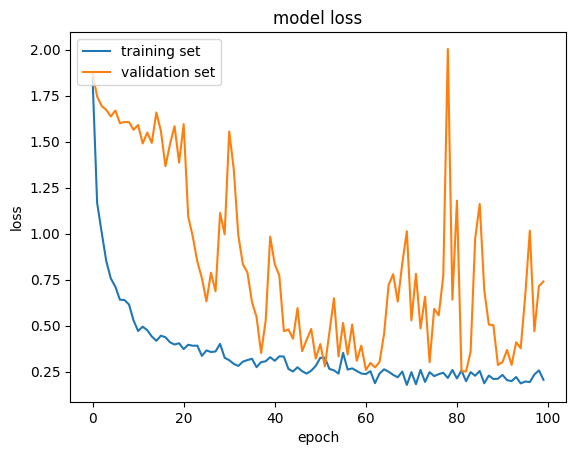

In [12]:
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper left')
plt.show()

In [13]:
y_true = test_generator.labels
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob,axis=1)

recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1s = f1_score(y_true, y_pred, average='macro')

print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1: {f1s}')

print(classification_report(y_true,y_pred))

4/4 [==============================] - 9s 3s/step
Recall: 0.6783346283346283
Precision: 0.6734642662302237
F1: 0.6223347003238309
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.85      1.00      0.92        11
           2       0.60      0.82      0.69        11
           3       0.33      0.67      0.44         3
           4       0.36      0.82      0.50        11
           5       1.00      0.54      0.70        13
           6       1.00      0.30      0.46        27
           7       0.91      0.96      0.93        45

    accuracy                           0.73       124
   macro avg       0.67      0.68      0.62       124
weighted avg       0.83      0.73      0.72       124

